## Útkeresés

In [9]:
import pygame
import sys
import math
import heapq
import numpy as np

class PathFinder:
    def heuristic(self, actual, end):
        return math.sqrt(pow(actual[0]-end[0],2) + pow(actual[1]-end[1],2))

    def astar(self, grid, start, goal):
        rows, cols = len(grid), len(grid[0])
        open_set = [(0, start)]
        came_from = {}
        g_score = {start: 0}

        while open_set:
            current_node = heapq.heappop(open_set)[1]
            if current_node == goal:
                path = []
                while current_node in came_from:
                    path.append(current_node)
                    current_node = came_from[current_node]
                path.append(start)
                return path[::-1]

            for neighbor in [(1, 0), (0, 1), (-1, 0), (0, -1)]:
                neighbor_node = (current_node[0] + neighbor[0], current_node[1] + neighbor[1])
                if 0 <= neighbor_node[0] < rows and 0 <= neighbor_node[1] < cols and grid[neighbor_node[0]][neighbor_node[1]] != 2:
                    grid[neighbor_node[0]][neighbor_node[1]] = 3
                    tentative_g_score = g_score[current_node] + 1
                    if neighbor_node not in g_score or tentative_g_score < g_score[neighbor_node]:
                        g_score[neighbor_node] = tentative_g_score
                        f_score = tentative_g_score + self.heuristic(neighbor_node, goal)
                        heapq.heappush(open_set, (f_score, neighbor_node))
                        came_from[neighbor_node] = current_node

        return None

class PathSpline:
    control_points = []
    spline_points = []
    def convert_to_main_coordinate(self, value,cell_height):
        return (value[1]*cell_height+0.5*cell_height+gui.textbox_margin,value[0]*cell_height+0.5*cell_height+gui.textbox_margin*2)

    def control_point_smoothing(self, path, cell_height):
        for i in range(0,len(path)-2):
            if self.convert_to_main_coordinate(path[i], cell_height) in self.control_points:
                control_index = self.control_points.index(self.convert_to_main_coordinate(path[i], cell_height))
                if self.convert_to_main_coordinate(path[i+1], cell_height) in self.control_points and self.convert_to_main_coordinate(path[i+2], cell_height):
                    j = i+1
                    while self.convert_to_main_coordinate(path[j], cell_height) in self.control_points and j < len(path)-1:
                        self.control_points.remove(self.convert_to_main_coordinate(path[j], cell_height))
                        j+=1
                    if j <len(path)-2:
                        self.control_points.insert(control_index+1, self.convert_to_main_coordinate(path[j], cell_height))
                elif self.convert_to_main_coordinate(path[i+1], cell_height) in self.control_points:
                    self.control_points.remove(self.convert_to_main_coordinate(path[j], cell_height))
                    self.control_points.insert(control_index+1, self.convert_to_main_coordinate(path[i+2], cell_height))

    def create_catmull_rom_spline(self):
        self.control_points = [self.control_points[0]] + self.control_points + [self.control_points[-1]]
        for i in range(1, len(self.control_points) - 2):
            for t in np.linspace(0, 1, 100):
                self.spline_point = self.catmull_rom_spline(self.control_points[i - 1], self.control_points[i], self.control_points[i + 1],  self.control_points[i + 2], t)
                self.spline_points.append(self.spline_point)
        self.spline_points = np.array(self.spline_points)

    def drawSpline(self):
        for point in self.spline_points:
            pygame.draw.circle(gui.screen, Constants.WHITE, (int(point[0]), int(point[1])), 2)
        for point in self.control_points:
            pygame.draw.circle(gui.screen, Constants.SECONDARY_BLUE, point, 5)

    # Catmull-Rom spline interpolation function
    def catmull_rom_spline(self, p0, p1, p2, p3, t):
        t2 = t * t
        t3 = t2 * t
        return 0.5 * ((2 * p1[0]) + (-p0[0] + p2[0]) * t + (2 * p0[0] - 5 * p1[0] + 4 * p2[0] - p3[0]) * t2 + (-p0[0] + 3 * p1[0] - 3 * p2[0] + p3[0]) * t3), 0.5 * ((2 * p1[1]) +(-p0[1] + p2[1]) * t +(2 * p0[1] - 5 * p1[1] + 4 * p2[1] - p3[1]) * t2 +(-p0[1] + 3 * p1[1] - 3 * p2[1] + p3[1]) * t3)
    
    def setupSpline(self):
        path = pf.astar(gui.grid_map, gui.endpoints[0], gui.endpoints[1])
        direction = (path[1][0]-path[0][0], path[1][1]-path[0][1])
        newDirection = direction
        actual = path[0] 
        self.control_points.append(self.convert_to_main_coordinate(actual, gui.cell_height))
        for i in range(0,len(path)):
            gui.grid_map[path[i][0]][path[i][1]] = 4
            if i != 0: 
                newDirection = (path[i][0]-path[i-1][0], path[i][1]-path[i-1][1])
            if(direction != newDirection):
                direction = newDirection
                self.control_points.append(self.convert_to_main_coordinate(actual, gui.cell_height))
            actual = path[i]
        self.control_points.append(self.convert_to_main_coordinate(path[-1], gui.cell_height))
        self.control_point_smoothing(path, gui.cell_height)
        self.create_catmull_rom_spline()

class Constants:
    SCREEN_WIDTH, SCREEN_HEIGHT = 800, 600
    BLACK = (0, 0, 0)
    WHITE = (255, 255, 255)
    GREY = (150, 150, 150)
    PRIMARY_BLUE = (50, 50, 255)
    SECONDARY_BLUE = (70, 70, 255)
    ORANGE = (242, 121, 53)
    RED = (175, 65, 84)
    GREEN = (0, 66, 37)
    FONT_SIZE = 36
    TEXT_COLOR = (0, 0, 0)
    CURSOR_COLOR = (0, 0, 0)
    WIDTH, HEIGHT = 800, 600
    WHITE = (255, 255, 255)
    RED = (255, 0, 0)
    STARTINGPOSITION = (WIDTH // 2,HEIGHT // 2)
    DOTPERMETER = 5
    EPSILON = 0.2
    CARLENGTH = 5
    CARWIDTH = .423
    SPEED = 6.94*12 # m/s -> 25*X km/h
# Initialize Pygame
pygame.init()
pygame.display.set_caption("CONTINENTAL")

class GUI:
    textbox_width = 150
    textbox_height = 40
    textbox_margin = 5
    textbox_rect1 = pygame.Rect((Constants.SCREEN_WIDTH - 3 * textbox_width - 2 * textbox_margin) // 2, Constants.SCREEN_HEIGHT - textbox_height - textbox_margin, textbox_width, textbox_height)
    textbox_rect2 = pygame.Rect(textbox_rect1.right + textbox_margin, Constants.SCREEN_HEIGHT - textbox_height - textbox_margin, textbox_width, textbox_height)
    button_rect = pygame.Rect(textbox_rect2.right + textbox_margin, Constants.SCREEN_HEIGHT - textbox_height - textbox_margin, textbox_width, textbox_height)
    input_text1 = ""
    input_text2 = ""
    cursor_blink_timer = 0
    cursor_visible = True
    active_textbox = 1
    generate_grid = False
    cell_height = None
    font = pygame.font.Font(None, Constants.FONT_SIZE)
    screen = pygame.display.set_mode((Constants.SCREEN_WIDTH, Constants.SCREEN_HEIGHT))
    drawing_spline = False
    number1 = 20
    number2 = 30
    grid_map = None
    endpoints = []
    def drawComponents(self):
        self.drawControls()
        if self.generate_grid:
            self.drawGrid()
    def generate_grid_map(self, value1, value2):
        return [[0 for _ in range(value2)] for _ in range(value1)]
    def drawControls(self):
        pygame.draw.rect(self.screen, Constants.BLACK, self.textbox_rect1, 2 if self.active_textbox == 1 else 1)
        pygame.draw.rect(self.screen, Constants.BLACK, self.textbox_rect2, 2 if self.active_textbox == 2 else 1)
        # Render input text 1
        text_surface1 = self.font.render(self.input_text1, True, Constants.TEXT_COLOR)
        text_rect1 = text_surface1.get_rect(midleft=(self.textbox_rect1.left + 5, self.textbox_rect1.centery))
        self.screen.blit(text_surface1, text_rect1)
        # Render input text 2
        text_surface2 = self.font.render(self.input_text2, True, Constants.TEXT_COLOR)
        text_rect2 = text_surface2.get_rect(midleft=(self.textbox_rect2.left + 5, self.textbox_rect2.centery))
        self.screen.blit(text_surface2, text_rect2)
        # Render OK button
        pygame.draw.rect(self.screen, Constants.SECONDARY_BLUE if self.button_rect.collidepoint(pygame.mouse.get_pos()) else Constants.PRIMARY_BLUE, self.button_rect)
        button_text = self.font.render("OK", True, Constants.TEXT_COLOR)
        button_text_rect = button_text.get_rect(center=self.button_rect.center)
        self.screen.blit(button_text, button_text_rect)

    def drawGrid(self):
        for i in range(self.number1):
            for j in range(self.number2):
                cell_rect = pygame.Rect(j * self.cell_height + self.textbox_margin, i * self.cell_height + 2 * self.textbox_margin, self.cell_height, self.cell_height)
                if self.grid_map[i][j] == 1:
                    pygame.draw.rect(self.screen, Constants.PRIMARY_BLUE, cell_rect)
                elif self.grid_map[i][j] == 2:
                    pygame.draw.rect(self.screen, Constants.BLACK, cell_rect)
                elif self.grid_map[i][j] == 3:
                    []
                    #pygame.draw.rect(self.screen, Constants.ORANGE, cell_rect)
                elif self.grid_map[i][j] == 4:
                    pygame.draw.rect(self.screen, Constants.RED, cell_rect)
                pygame.draw.rect(self.screen, Constants.GREY, cell_rect, 1)
    
    def setupGrid(self):      
        if self.is_numeric(self.input_text1) and self.is_numeric(self.input_text2):
            self.number1 = int(self.input_text1)
            self.number2 = int(self.input_text2)
            self.grid_map = self.generate_grid_map(self.number1, self.number2)
            self.generate_grid = True
            self.cell_height = (Constants.SCREEN_HEIGHT - 3 * self.textbox_margin - 2 * self.textbox_height)// self.number1
            return True
        return False
    
    def is_numeric(self,text):
        try:
            int(text)
            return True
        except ValueError:
            return False

    def okButtonPress(self):
        return self.setupGrid()
    
    def handleKeyDown(self):
        if event.key == pygame.K_TAB:
                    self.active_textbox = 3 - self.active_textbox
        elif event.key == pygame.K_RETURN:
            return self.setupGrid()
        elif event.key == pygame.K_BACKSPACE:
            if self.active_textbox == 1:
                self.input_text1 = self.input_text1[:-1]
            elif self.active_textbox == 2:
                self.input_text2 = self.input_text2[:-1]
        elif event.unicode.isnumeric():
            if self.active_textbox == 1:
                self.input_text1 += event.unicode
            elif self.active_textbox == 2:
                self.input_text2 += event.unicode
        return False
    
    def handleClick(self):
        for i in range(self.number1):
            for j in range(self.number2):
                cell_rect = pygame.Rect(j * self.cell_height + self.textbox_margin, i * self.cell_height + 2 * self.textbox_margin, self.cell_height, self.cell_height)
                if cell_rect.collidepoint(event.pos):
                    if event.button == 1:
                        self.grid_map[i][j] = 2
                        return False
                    elif event.button == 3:
                        self.endpoints.append((i,j))
                        self.grid_map[i][j] = 1 
                        return True
        return False

class Vehicle:
    # Car properties
    move_interval = 1 
    model = None
    position = 0
    angle = 0
    
    def blitRotate(self,surf, image, pos, originPos, angle):
        image_rect = image.get_rect(topleft = (pos[0] - originPos[0], pos[1]-originPos[1]))
        offset_center_to_pivot = pygame.math.Vector2(pos) - image_rect.center
        rotated_offset = offset_center_to_pivot.rotate(-angle)
        rotated_image_center = (pos[0] - rotated_offset.x, pos[1] - rotated_offset.y)
        rotated_image = pygame.transform.rotate(image, angle)
        rotated_image_rect = rotated_image.get_rect(center = rotated_image_center)
        surf.blit(rotated_image, rotated_image_rect)
        
    def drawVehicle(self):
        if len(spline.spline_points)-1 <= self.position:
            self.position = 0
        if pygame.time.get_ticks() % self.move_interval == 0:
            vector = (spline.spline_points[self.position][0] - spline.spline_points[self.position+1][0], spline.spline_points[self.position][1] - spline.spline_points[self.position+1][1])
            self.blitRotate(gui.screen, self.model, (spline.spline_points[self.position][0], spline.spline_points[self.position][1]), (self.model.get_width()/2, self.model.get_height()/2), -math.degrees(math.atan2(vector[1], vector[0])))
            gui.screen.blit(self.model, (1, 1))
            self.position += 1
            pygame.draw.rect(self.model, (0, 233, 0), (1, 1, self.model.get_width(), self.model.get_height())) 




## Movement definition

#### imports

In [10]:
import numpy as np
import pygame
from typing import Tuple

def normalize_radians(radians):
    normalized_radians = radians % (2 * np.pi)  
    if normalized_radians > np.pi:
        normalized_radians -= 2 * np.pi
    return normalized_radians

#### constants

In [11]:
WIDTH, HEIGHT = 800, 600
WHITE = (255, 255, 255)
RED = (255, 0, 0)
STARTINGPOSITION = (WIDTH // 2,HEIGHT // 2)
DOTPERMETER = 10
EPSILON = 0.2
CARLENGTH = 5
CARWIDTH = .423
SPEED = 6.94*2.5 # m/s -> 25*X km/h


#### car definition

Using kinematic bike model  
with positioniong the reference point on the center of gravity  
  
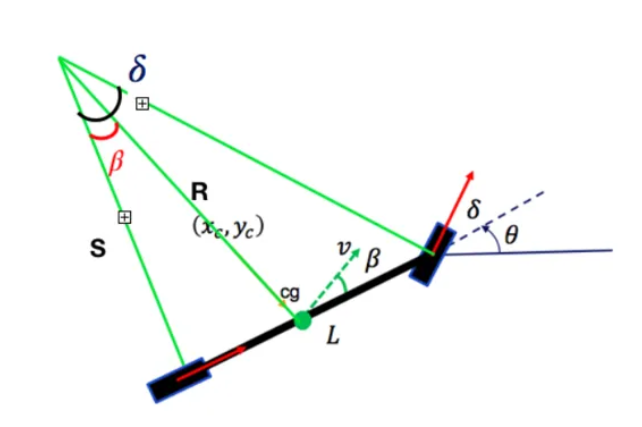

In [12]:
class Car:
    def __init__(self, maxSteeringAngle : float, position : Tuple[float, float] , maxSpeed : float, headingAngle : float, length : float):
        """ angles in radians """
        self.__maxSteeringAngle = maxSteeringAngle
        """in radian"""
        self.__position = position
        self.__maxSpeed = maxSpeed
        self.__headingAngle = headingAngle
        """theta, in radian"""

        
        self.__steeringRate = 0

        self.__steeringAngle = 0.0
        """gamma, in radian"""
        self.__length = length
        self.__speed = 0

    def get_position(self) -> Tuple[float, float]:
        return self.__position
    
    def set_position(self, position : Tuple[float, float]):
        self.__position = position

    def set_speed_rate(self, rate : float):
        """between 1 (max speed forward) and -1 (max speed backward)"""
        self.__speed = self.__maxSpeed * rate

    def get_speed(self):
        return self.__speed

    def get_heading_angle(self):
        """in radian"""
        return self.__headingAngle
    
    def get_max_steering_angle(self):
        """in radian"""
        return self.__maxSteeringAngle

    def set_steering_rate(self, rate : float):
        """between 1 (fully left) and -1 (fully right)"""
        self.__steeringAngle = self.__maxSteeringAngle * rate
        self.__steeringRate = rate

    def get_steering_rate(self):
        return self.__steeringRate

    def get_steering_angle(self):
        """in radian"""
        return self.__steeringAngle
    
    def get_car_length(self):
        return self.__length

    def travel(self, dt : float):
        beta = np.arctan(self.__length/2 * np.tan(self.__steeringAngle) / self.__length)
        posUpdate = (np.cos(beta+self.__headingAngle),np.sin(beta+self.__headingAngle))
        self.__position = np.add(self.__position, np.multiply((posUpdate[0], -posUpdate[1]), self.__speed * dt * DOTPERMETER))
        self.__headingAngle = normalize_radians(self.__headingAngle + (self.__speed*np.tan(self.__steeringAngle) *np.cos(beta) / self.__length)*dt)

    def get_turning_radius(self, rate : float):
        return self.__length / np.tan(self.__maxSteeringAngle * rate)

#instantiation
drivingCar = Car(maxSteeringAngle=np.deg2rad(40),
          position=STARTINGPOSITION,
          maxSpeed=SPEED,
          headingAngle=0.0,
          length= CARLENGTH) #5 meters long

#### self driving

follows cursor

In [13]:
def findSteeringRate(car : Car, desiredPosition : Tuple[float, float], epsilon):
    headingAngle = car.get_heading_angle()
    maxSteeringAngle = car.get_max_steering_angle()
    carPosition = car.get_position()
    headingDir = (np.cos(headingAngle), -np.sin(headingAngle))
    frontBumperPos = np.add(carPosition, np.multiply(car.get_car_length()/2*DOTPERMETER, headingDir))

    dirX = desiredPosition[0] - frontBumperPos[0]
    dirY = frontBumperPos[1] - desiredPosition[1]
    desiredHeading = np.arctan2(dirY, dirX)

    difference =  desiredHeading - headingAngle
    #str(tuple("{:.2f}".format(elem) for elem in carPosition))
    print("desired pos: " + str(tuple("{:.2f}".format(elem) for elem in desiredPosition)))
    print("curr pos: " + str(tuple("{:.2f}".format(elem) for elem in carPosition)))
    print("headingangle: " + str(format(headingAngle, '.2f')))
    print("desired heading: " + str(format(desiredHeading, '.2f')) + "\tdirX: " + str(format(dirX, '.2f')) + "\tdirY: " + str(format(dirY,'.2f')))

    #(np.pi - desiredHeading)
    #(desiredHeading - np.pi)
    
    
    if np.abs(desiredHeading - headingAngle) > np.pi:
        if desiredHeading - headingAngle < 0:
            difference =  + ((desiredHeading - headingAngle) % np.pi)
        elif desiredHeading - headingAngle >0:
            difference =  - ((+ headingAngle -desiredHeading ) % np.pi)
            print("! diff:" + str(difference))
        

    if np.abs(difference - np.pi) <epsilon :
            return 0
    rate = difference/maxSteeringAngle

    if rate > 1 : rate = 1
    elif rate < -1 : rate = -1
    elif np.abs(rate) < epsilon: rate = 0

    if car.get_speed() <0 : rate *=-1

    return rate

#### visual demo

The car is 5 meters long, drives at 15 km/h. Taking the feet off the gas pedal results in instant stop.

In [14]:
pygame.init()
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Move Object with Arrow Keys")
carImage = pygame.image.load("media/rect.png")
carImage = pygame.transform.scale(surface= carImage, size=[ CARLENGTH*DOTPERMETER, CARWIDTH*DOTPERMETER])
wheelImage = pygame.image.load("media/wheel.png")
wheelImage = pygame.transform.scale(surface= wheelImage, size=[ CARLENGTH*DOTPERMETER/3, CARWIDTH*DOTPERMETER*2])
trackImage = pygame.image.load("media/track.png").convert_alpha()

def translate_position(vector : Tuple[float, float], angle : float, length:float):
    """angle in radian"""
    newX = vector[0] + length * np.cos(angle)
    newY = vector[1] - length * np.sin(angle)

    return (newX, newY)

running = True

In [15]:
""" drawTrack = False
followCursor = False
while running:
    screen.fill(WHITE)
    
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        if event.type == pygame.KEYDOWN :
            if event.key == pygame.K_w :    #forward
                drivingCar.set_speed_rate(1.0)
            elif event.key == pygame.K_s :  #backward
                drivingCar.set_speed_rate(-1.0)
            if event.key == pygame.K_a :    #left
                drivingCar.set_steering_rate(1.0)
            elif event.key == pygame.K_d :  #right
                drivingCar.set_steering_rate(-1.0)
            if event.key == pygame.K_m :    #draw map
                drawTrack = not drawTrack
            if event.key == pygame.K_f:     #follow cursor
                followCursor = not followCursor

                
        elif event.type == pygame.KEYUP :
            if event.key == pygame.K_w or event.key == pygame.K_s :
                drivingCar.set_speed_rate(0.0)
            if event.key == pygame.K_a or event.key == pygame.K_d :
                drivingCar.set_steering_rate(0)

    if followCursor:
        drivingCar.set_steering_rate(findSteeringRate(drivingCar, pygame.mouse.get_pos(), EPSILON))
                
    drivingCar.travel(1.0/120) #1/120 seconds per frame

    rotated_car = pygame.transform.rotate(carImage,angle = np.rad2deg(drivingCar.get_heading_angle()))
    car_rect = rotated_car.get_rect(center=drivingCar.get_position())

    front_wheel = pygame.transform.rotate(wheelImage,angle = np.rad2deg(drivingCar.get_heading_angle()+drivingCar.get_steering_angle()))
    front_wheel_rect = front_wheel.get_rect(center=translate_position(drivingCar.get_position(), drivingCar.get_heading_angle(), carImage.get_width()/2.0))
    rear_wheel = pygame.transform.rotate(wheelImage,angle = np.rad2deg(drivingCar.get_heading_angle()))
    rear_wheel_rect = rear_wheel.get_rect(center=translate_position(drivingCar.get_position(), drivingCar.get_heading_angle(), -carImage.get_width()/2.0))
    
    if drawTrack:
        screen.blit(trackImage, (0,0))
    screen.blit(rotated_car, car_rect.topleft)
    screen.blit(front_wheel, front_wheel_rect.topleft)
    screen.blit(rear_wheel, rear_wheel_rect.topleft)

    # Keep the car object within the screen boundaries
    x = max(0, min(drivingCar.get_position()[0], WIDTH))
    y = max(0, min(drivingCar.get_position()[1], HEIGHT))
    drivingCar.set_position((x, y))
    
    pygame.display.flip()
    pygame.time.Clock().tick(120)

pygame.quit() """

' drawTrack = False\nfollowCursor = False\nwhile running:\n    screen.fill(WHITE)\n    \n    for event in pygame.event.get():\n        if event.type == pygame.QUIT:\n            running = False\n        if event.type == pygame.KEYDOWN :\n            if event.key == pygame.K_w :    #forward\n                drivingCar.set_speed_rate(1.0)\n            elif event.key == pygame.K_s :  #backward\n                drivingCar.set_speed_rate(-1.0)\n            if event.key == pygame.K_a :    #left\n                drivingCar.set_steering_rate(1.0)\n            elif event.key == pygame.K_d :  #right\n                drivingCar.set_steering_rate(-1.0)\n            if event.key == pygame.K_m :    #draw map\n                drawTrack = not drawTrack\n            if event.key == pygame.K_f:     #follow cursor\n                followCursor = not followCursor\n\n                \n        elif event.type == pygame.KEYUP :\n            if event.key == pygame.K_w or event.key == pygame.K_s :\n           

In [16]:
# Main loop
running = True
clock = pygame.time.Clock()
step = 0
spline = PathSpline()
pf = PathFinder()
gui = GUI()
vehicle = Vehicle()
drawTrack = False
followCursor = False
while running:
    gui.screen.fill(Constants.WHITE)
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        elif step == 0:
            if event.type == pygame.KEYDOWN:
                if gui.handleKeyDown():
                    step = 1
            elif event.type == pygame.MOUSEBUTTONDOWN:
                if gui.button_rect.collidepoint(event.pos):
                    if gui.okButtonPress():
                        step = 1
        elif step == 1 or step == 2:
            if event.type == pygame.MOUSEBUTTONDOWN:
                vehicle.model = pygame.Surface((gui.cell_height, gui.cell_height/2), pygame.SRCALPHA)
                if gui.handleClick():
                    step+=1
                if step == 3: 
                    spline.setupSpline()
        if event.type == pygame.QUIT:
            running = False
        if event.type == pygame.KEYDOWN :
            if event.key == pygame.K_w :    #forward
                drivingCar.set_speed_rate(1.0)
            elif event.key == pygame.K_s :  #backward
                drivingCar.set_speed_rate(-1.0)
            if event.key == pygame.K_a :    #left
                drivingCar.set_steering_rate(1.0)
            elif event.key == pygame.K_d :  #right
                drivingCar.set_steering_rate(-1.0)
            if event.key == pygame.K_m :    #draw map
                drawTrack = not drawTrack
            if event.key == pygame.K_f:     #follow cursor
                followCursor = not followCursor
        elif event.type == pygame.KEYUP :
            if event.key == pygame.K_w or event.key == pygame.K_s :
                drivingCar.set_speed_rate(0.0)
            if event.key == pygame.K_a or event.key == pygame.K_d :
                drivingCar.set_steering_rate(0)
    if followCursor:
       #drivingCar.set_steering_rate(findSteeringRate(drivingCar, pygame.mouse.get_pos(), EPSILON))
        #check if spline.spline_points is not empty
        if len(spline.spline_points) > 0:
            drivingCar.set_steering_rate(findSteeringRate(drivingCar, spline.spline_points[vehicle.position], EPSILON))

            carP = translate_position(drivingCar.get_position(), drivingCar.get_heading_angle(), carImage.get_width()/2.0)
            minDist = np.inf
            minIndex = 0
            for i in range(len(spline.spline_points)):
                dist = np.linalg.norm(np.subtract(spline.spline_points[i], carP))
                if dist < minDist:
                    minDist = dist
                    minIndex = i
            minIndex += 2
            #if minIndex is out of bounds, set it to the last index
            if minIndex >= len(spline.spline_points):
                minIndex = len(spline.spline_points) - 1
            drivingCar.set_steering_rate(findSteeringRate(drivingCar, spline.spline_points[minIndex], EPSILON))



    drivingCar.travel(1.0/120) #1/120 seconds per frame

    rotated_car = pygame.transform.rotate(carImage,angle = np.rad2deg(drivingCar.get_heading_angle()))
    car_rect = rotated_car.get_rect(center=drivingCar.get_position())

    front_wheel = pygame.transform.rotate(wheelImage,angle = np.rad2deg(drivingCar.get_heading_angle()+drivingCar.get_steering_angle()))
    front_wheel_rect = front_wheel.get_rect(center=translate_position(drivingCar.get_position(), drivingCar.get_heading_angle(), carImage.get_width()/2.0))
    rear_wheel = pygame.transform.rotate(wheelImage,angle = np.rad2deg(drivingCar.get_heading_angle()))
    rear_wheel_rect = rear_wheel.get_rect(center=translate_position(drivingCar.get_position(), drivingCar.get_heading_angle(), -carImage.get_width()/2.0))
    

    if drawTrack:
        screen.blit(trackImage, (0,0))
    
    gui.drawComponents()
    if step == 3: 
        spline.drawSpline()
        #vehicle.drawVehicle()
    screen.blit(rotated_car, car_rect.topleft)
    screen.blit(front_wheel, front_wheel_rect.topleft)
    screen.blit(rear_wheel, rear_wheel_rect.topleft)

    # Keep the car object within the screen boundaries
    x = max(0, min(drivingCar.get_position()[0], WIDTH))
    y = max(0, min(drivingCar.get_position()[1], HEIGHT))
    drivingCar.set_position((x, y))

    

    pygame.display.flip()
    clock.tick(120)
    
pygame.quit()
sys.exit()

desired pos: ('317.50', '297.50')
curr pos: ('259.75', '300.00')
headingangle: 0.00
desired heading: 0.08	dirX: 32.75	dirY: 2.50
desired pos: ('318.84', '297.52')
curr pos: ('259.75', '300.00')
headingangle: 0.00
desired heading: 0.07	dirX: 34.08	dirY: 2.48
desired pos: ('317.50', '297.50')
curr pos: ('259.75', '300.00')
headingangle: 0.00
desired heading: 0.08	dirX: 32.75	dirY: 2.50
desired pos: ('318.84', '297.52')
curr pos: ('259.75', '300.00')
headingangle: 0.00
desired heading: 0.07	dirX: 34.08	dirY: 2.48
desired pos: ('317.50', '297.50')
curr pos: ('259.75', '300.00')
headingangle: 0.00
desired heading: 0.08	dirX: 32.75	dirY: 2.50
desired pos: ('318.84', '297.52')
curr pos: ('259.75', '300.00')
headingangle: 0.00
desired heading: 0.07	dirX: 34.08	dirY: 2.48
desired pos: ('317.50', '297.50')
curr pos: ('259.75', '300.00')
headingangle: 0.00
desired heading: 0.08	dirX: 32.75	dirY: 2.50
desired pos: ('318.84', '297.52')
curr pos: ('259.75', '300.00')
headingangle: 0.00
desired headi

SystemExit: 